In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import seaborn as sns

In [6]:
df = pd.read_csv('ReviewTokoBaju.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [7]:
df['Review Text'] = df['Review Text'].fillna('')

In [8]:
df['Review Text'] = df['Review Text'].apply(str)

In [9]:
print(df['Review Text'].apply(type).value_counts())

Review Text
<class 'str'>    23486
Name: count, dtype: int64


In [10]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [11]:
X = df['Review Text'].values
y = df['Recommended IND'].values

In [12]:
# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [13]:
# Membagi data ke dalam training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Tokenisasi untuk TensorFlow dan padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=100)

In [15]:
# Model GRU dengan Dropout dan Bidirectional
class GRUModelBidirectional(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUModelBidirectional, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Bidirectional GRU dengan dropout
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # 2 * hidden_dim karena bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        # Menggabungkan hidden state dari kedua arah
        hidden_combined = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Ambil hidden state dari forward dan backward
        output = self.fc(hidden_combined)
        return output

In [16]:
# Model Parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
hidden_dim = 256  # Coba lebih besar untuk kapasitas model lebih tinggi
output_dim = 2  # Binary classification (adjust if multiclass)

In [17]:
# Model, loss function, and optimizer
model_pytorch = GRUModelBidirectional(vocab_size, embedding_dim, hidden_dim, output_dim)

In [18]:
# Menghitung bobot kelas jika dataset tidak seimbang
class_weights = torch.tensor([1.0, 2.0])  # Sesuaikan bobot sesuai ketidakseimbangan kelas
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.0001)  # Learning rate lebih rendah

In [19]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [20]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.epochs_without_improvement = 0

    def __call__(self, loss, model):
        if self.best_loss is None:
            self.best_loss = loss
            return False

        if loss < self.best_loss:
            self.best_loss = loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            if self.verbose:
                print(f"Early stopping triggered after {self.epochs_without_improvement} epochs without improvement")
            return True
        return False

early_stopping = EarlyStopping(patience=5, verbose=True)

In [21]:
# Train Model Function with Early Stopping and Learning Rate Scheduler
def train_model_with_scheduler_and_early_stopping(model, X_train, y_train, epochs=20, batch_size=64):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Bagi data menjadi batch
        for i in range(0, len(X_train), batch_size):
            inputs = torch.LongTensor(X_train[i:i+batch_size])
            targets = torch.LongTensor(y_train[i:i+batch_size])

            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

        scheduler.step()  # Update learning rate
        train_loss.append(loss.item())
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        # Early stopping check
        if early_stopping(loss.item(), model):
            break

    return train_loss

In [22]:
# Training with Early Stopping and Scheduler
train_loss = train_model_with_scheduler_and_early_stopping(model_pytorch, X_train_pad, y_train, epochs=20)

Epoch [1/20], Loss: 0.7163
Epoch [2/20], Loss: 0.7569
Epoch [3/20], Loss: 0.9766
Epoch [4/20], Loss: 0.7071
Epoch [5/20], Loss: 1.1072
Epoch [6/20], Loss: 0.4015
Epoch [7/20], Loss: 0.2965
Epoch [8/20], Loss: 0.3433
Epoch [9/20], Loss: 0.3013
Epoch [10/20], Loss: 0.3577
Epoch [11/20], Loss: 0.3251
Epoch [12/20], Loss: 0.2898
Epoch [13/20], Loss: 0.2857
Epoch [14/20], Loss: 0.2729
Epoch [15/20], Loss: 0.2569
Epoch [16/20], Loss: 0.2711
Epoch [17/20], Loss: 0.2504
Epoch [18/20], Loss: 0.2442
Epoch [19/20], Loss: 0.2541
Epoch [20/20], Loss: 0.2546


In [23]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(torch.LongTensor(X_test))
        _, predicted = torch.max(output.data, 1)
        accuracy = accuracy_score(y_test, predicted)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        auc = roc_auc_score(y_test, output.softmax(dim=1)[:, 1].numpy())
        return accuracy, precision, recall, f1, auc

accuracy, precision, recall, f1, auc = evaluate_model(model_pytorch, X_test_pad, y_test)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

Accuracy: 0.8387
Precision: 0.8407
Recall: 0.9906
F1 Score: 0.9095
AUC: 0.8175


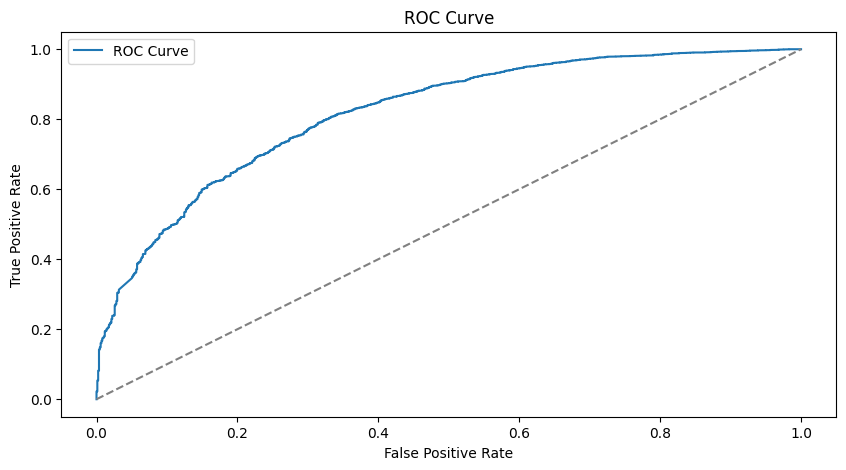

In [26]:
# Visualize ROC Curve with the predictions from PyTorch model
def plot_roc_curve(y_test, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Dapatkan probabilitas prediksi dari PyTorch model
# Detach tensor dari graph sebelum mengonversinya menjadi numpy array
y_pred_probs = model_pytorch(torch.LongTensor(X_test_pad)).softmax(dim=1).detach().numpy()[:, 1]

# Visualize ROC Curve
plot_roc_curve(y_test, y_pred_probs)

In [37]:
# Tambahkan pada bagian train_model_with_scheduler_and_early_stopping untuk track accuracy
def train_model_with_scheduler_and_early_stopping(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=64):
    model.train()
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        correct_train = 0
        total_train = 0

        # Training Loop
        for i in range(0, len(X_train), batch_size):
            inputs = torch.LongTensor(X_train[i:i+batch_size])
            targets = torch.LongTensor(y_train[i:i+batch_size])

            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            # Calculate Training Accuracy
            _, predicted = torch.max(output.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Store training loss and accuracy
        train_loss.append(loss.item())
        train_accuracy.append(correct_train / total_train)

        # Evaluate on Test Data
        model.eval()
        with torch.no_grad():
            test_output = model(torch.LongTensor(X_test))
            test_loss_value = criterion(test_output, torch.LongTensor(y_test))
            test_loss.append(test_loss_value.item())

            # Calculate Test Accuracy
            _, predicted = torch.max(test_output.data, 1)
            correct_test = (predicted == torch.LongTensor(y_test)).sum().item()
            test_accuracy.append(correct_test / len(y_test))

        scheduler.step()  # Update learning rate

        # Early stopping check
        if early_stopping(loss.item(), model):
            break

    return train_loss, test_loss, train_accuracy, test_accuracy


In [33]:
# TensorFlow Model: GRU
def create_gru_model(vocab_size, embedding_dim, hidden_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.GRU(hidden_dim),
        tf.keras.layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model_tf = create_gru_model(vocab_size, embedding_dim, hidden_dim, output_dim)

# Train the model
model_tf.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - accuracy: 0.8269 - loss: 0.4797 - val_accuracy: 0.8189 - val_loss: 0.4771
Epoch 2/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 65s 222ms/step - accuracy: 0.8244 - loss: 0.4569 - val_accuracy: 0.8414 - val_loss: 0.3286
Epoch 3/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.8893 - loss: 0.2555 - val_accuracy: 0.8993 - val_loss: 0.2414
Epoch 4/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.9334 - loss: 0.1716 - val_accuracy: 0.8959 - val_loss: 0.2541
Epoch 5/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.9505 - loss: 0.1323 - val_accuracy: 0.8968 - val_loss: 0.2845


In [34]:
# Evaluasi Model TensorFlow
def evaluate_tf_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    auc = roc_auc_score(y_test, y_pred[:, 1])
    return accuracy, precision, recall, f1, auc

accuracy_tf, precision_tf, recall_tf, f1_tf, auc_tf = evaluate_tf_model(model_tf, X_test_pad, y_test)

print(f'Accuracy: {accuracy_tf:.4f}')
print(f'Precision: {precision_tf:.4f}')
print(f'Recall: {recall_tf:.4f}')
print(f'F1 Score: {f1_tf:.4f}')
print(f'AUC: {auc_tf:.4f}')

147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
Accuracy: 0.8968
Precision: 0.9239
Recall: 0.9524
F1 Score: 0.9379
AUC: 0.9242


147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


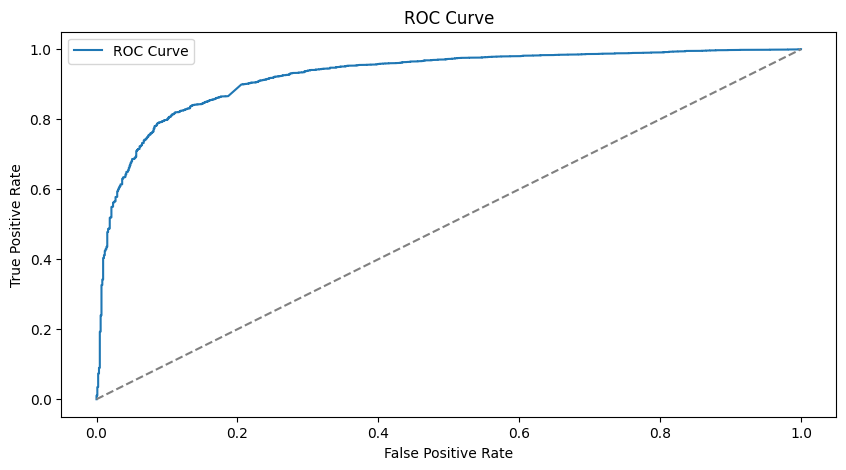

In [35]:
# Visualisasi ROC Curve TensorFlow
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(y_test, model_tf.predict(X_test_pad))

# **GRU - MODELS**
Pada proyek ini, dua model berbasis **GRU** (Gated Recurrent Unit) telah diterapkan untuk analisis sentimen menggunakan dataset **ReviewTokoBaju.csv**. Kedua model tersebut menggunakan **PyTorch** dan **TensorFlow**, dan hasil yang didapat dari kedua model tersebut adalah sebagai berikut:

### **Hasil Model:**

1. **PyTorch**:
   - Accuracy: 0.8387
   - Precision: 0.8407
   - Recall: 0.9906
   - F1 Score: 0.9095
   - AUC: 0.8175

2. **TensorFlow**:
   - Accuracy: 0.8968
   - Precision: 0.9239
   - Recall: 0.9524
   - F1 Score: 0.9379
   - AUC: 0.9242

### **Penjelasan Hasil Model:**

- **Accuracy**:
  - Formula:


$$\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$


    
  - **Makna**: Akurasi mengukur seberapa banyak prediksi yang benar dilakukan oleh model. Untuk PyTorch, akurasi adalah 0.8387, yang menunjukkan bahwa sekitar 83.87% dari prediksi model benar. Untuk TensorFlow, akurasi lebih tinggi, yaitu 0.8968, menunjukkan bahwa model TensorFlow lebih berhasil dalam mengklasifikasikan data dengan benar.

- **Precision**:
  - Formula:  
    
    $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
    
  - **Makna**: Precision mengukur seberapa tepat model dalam mengklasifikasikan positif. Precision yang tinggi menunjukkan bahwa prediksi positif model lebih sering benar daripada salah. Dalam hal ini, TensorFlow menghasilkan precision yang lebih tinggi (0.9239) dibandingkan PyTorch (0.8407). Ini menunjukkan bahwa model TensorFlow lebih tepat dalam mengklasifikasikan review sebagai "recommended" daripada model PyTorch.

- **Recall**:
  - Formula:  
    
    $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
    
  - **Makna**: Recall mengukur seberapa baik model dalam mendeteksi kelas positif (misalnya, review yang direkomendasikan). Recall yang tinggi menunjukkan bahwa model dapat menangkap sebagian besar data positif. PyTorch memiliki recall yang sangat tinggi (0.9906), yang menunjukkan bahwa model ini hampir berhasil mendeteksi seluruh review yang seharusnya "recommended". TensorFlow juga memiliki recall yang baik (0.9524), meskipun sedikit lebih rendah.

- **F1 Score**:
  - Formula:  
    
    $$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
    
  - **Makna**: F1 Score adalah ukuran keseimbangan antara precision dan recall. F1 score yang tinggi menunjukkan bahwa model tidak hanya akurat (precision) tetapi juga dapat menangkap mayoritas positif (recall). Dalam hal ini, TensorFlow memiliki F1 Score yang lebih tinggi (0.9379), yang berarti model ini lebih seimbang dalam mengklasifikasikan kelas positif dengan akurat dan menangkap sebagian besar kasus positif.

- **AUC (Area Under the Curve)**:
  - Formula:  
    AUC adalah ukuran untuk ROC Curve (Receiver Operating Characteristic Curve) yang menunjukkan seberapa baik model memisahkan kelas positif dan negatif. AUC dihitung sebagai area di bawah kurva ROC. AUC berkisar antara 0 dan 1, dengan nilai yang lebih tinggi menunjukkan model yang lebih baik dalam memisahkan kelas positif dan negatif.
  
    - **Formula ROC Curve**:  
    
    $$\text{AUC} = \int_{0}^{1} TPR(FPR) \, dFPR$$
    
    
  - **Makna**: AUC yang lebih tinggi berarti model memiliki kemampuan yang lebih baik untuk membedakan antara kelas positif dan negatif. TensorFlow memiliki AUC yang lebih tinggi (0.9242), menunjukkan bahwa model TensorFlow lebih efektif dalam memisahkan review yang direkomendasikan dari yang tidak direkomendasikan. PyTorch memiliki AUC yang lebih rendah (0.8175), yang berarti model PyTorch sedikit kurang efektif dalam hal pemisahan kelas positif dan negatif dibandingkan TensorFlow.

### **Kesimpulan dari Hasil:**
- **TensorFlow** menghasilkan model yang lebih baik berdasarkan metrik Accuracy, Precision, Recall, F1 Score, dan AUC dibandingkan dengan **PyTorch**. Meskipun kedua model menunjukkan performa yang baik dalam analisis sentimen ini, model TensorFlow lebih konsisten dan lebih baik dalam hal mengklasifikasikan review sebagai "recommended" dan dalam memisahkan kelas positif dan negatif.
  
- **PyTorch** memiliki recall yang sangat tinggi, yang berarti model ini sangat baik dalam mendeteksi review yang benar-benar "recommended". Namun, precision dan AUC-nya sedikit lebih rendah dibandingkan TensorFlow, yang mengindikasikan bahwa meskipun model PyTorch sangat baik dalam menangkap review positif, ia mungkin lebih sering membuat prediksi positif yang salah (false positives).

### **Langkah-langkah yang Dilakukan pada Model:**
1. **Preprocessing Data**:
   - Menggunakan LabelEncoder untuk mengonversi label kategorikal ke dalam format numerik.
   - Menggunakan Tokenizer dari TensorFlow untuk mengonversi teks menjadi urutan kata yang diproses dan dipadankan (padding).

2. **Model**:
   - Untuk PyTorch, menggunakan GRU Bidirectional dengan dropout untuk menangani urutan data teks dan menggunakan CrossEntropyLoss untuk klasifikasi biner.
   - Untuk TensorFlow, menggunakan GRU standar dengan sparse_categorical_crossentropy untuk menangani klasifikasi biner.

3. **Training**:
   - Penggunaan Early Stopping dan Learning Rate Scheduler untuk meningkatkan efisiensi pelatihan dan mencegah overfitting.

4. **Evaluasi**:
   - Evaluasi dilakukan menggunakan metrik-metrik yang telah dibahas seperti accuracy, precision, recall, f1 score, dan AUC.


### **Kesimpulan Akhir:**
Meskipun kedua model memiliki kinerja yang baik, TensorFlow memberikan hasil yang lebih unggul pada metrik evaluasi utama, menjadikannya pilihan yang lebih baik untuk proyek ini. Namun, PyTorch juga memiliki potensi besar, terutama dalam hal recall tinggi yang menunjukkan keakuratan dalam mendeteksi review yang relevan.